### Library Import

In [12]:
import sys
sys.path.append('../')
import importlib


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from tqdm import tqdm

from sklearn.manifold import TSNE
import umap
import os

from lsnc import lsnc
import metrics as mts
importlib.reload(lsnc)
importlib.reload(mts)

## turn off warning
import warnings
warnings.filterwarnings("ignore")

dr_measures = [
	"ls_btw_ch", "lc_btw_ch",  "cohev", "stead",
	"trust", "conti", "mrre_hl", "mrre_lh",
	"kl_div", "dtm", "sil",
]
dr_measures_name = [
	"Label-Stretching", "Label-Compression", "Cohesiveness", "Steadiness", 
	"Trustworthiness", "Continuity", "MRRE [Missing]", "MRRE [False]",
	"1 - KL-Divergence", "1 - DTM", "Silhouette",
]
type = [
	"cluster", "cluster", "cluster", "cluster", 
	"local", "local", "local", "local",
	"global", "global", "cluster"
]
dr_measures_line_width = [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
linestyle_list = [
	"solid", "solid", "solid", "solid", 
	"dashed", "dashed", "dashed", "dashed",
	"dotted", "dotted", "solid"
]
k_cand = [5, 10, 15, 20, 25]
sigma_cand = [0.01, 0.1, 1]

In [13]:
def run_all_metrics(raw, emb, labels, k_cand, sigma_cand):
	"""
	compute all metrics
	"""
	final_results = {}

	## LS & LC
	lsnc_obj = lsnc.LSNC(raw, emb, labels)
	results = lsnc_obj.run()
	final_results["ls_btw_ch"] = results["ls"]
	final_results["lc_btw_ch"] = results["lc"]

	## Steadiness & Cohesiveness
	results = mts.stead_cohev(raw, emb)
	final_results["stead"] = results["stead"]
	final_results["cohev"] = results["cohev"]

	## Silhouette
	final_results["sil"] = mts.silhouette(emb, labels)

	## Trust / Conti / MRRE
	trust, conti, mrre_hl, mrre_lh = 0, 0, 0, 0
	for k in k_cand:
		results = mts.trust_conti_mrre(raw, emb, k = k)
		trust += results["trust"]
		conti += results["conti"]
		mrre_hl += results["mrre_hl"]
		mrre_lh += results["mrre_lh"]
	final_results["trust"] = trust / len(k_cand)
	final_results["conti"] = conti / len(k_cand)
	final_results["mrre_hl"] = mrre_hl / len(k_cand)
	final_results["mrre_lh"] = mrre_lh / len(k_cand)

	## KL / DTM
	kl_div, dtm = 0, 0, 
	for sigma in sigma_cand:
		results = mts.kl_div_rmse_dtm(raw, emb, sigma = sigma)
		kl_div += results["kl_div"]
		dtm += results["dtm"]
	final_results["kl_div"] = kl_div / len(sigma_cand)
	final_results["dtm"] = dtm / len(sigma_cand)
	results = mts.kl_div_rmse_dtm(raw, emb)

	return final_results	

In [14]:
## function to plot the results using seabron (line chart)
def lineplot_results(results_list_dict, title, x_list = None, invert_x_axis=False, ax=None, add_legend=True, y_label=None, x_label=None):

	results_list_dict["kl_div"] = [1 - x for x in results_list_dict["kl_div"]]
	results_list_dict["dtm"] = [1 - x for x in results_list_dict["dtm"]]

	if (x_list is None):
		x_list = range(1, len(results_list_dict["kl_div"]) + 1)

	plt_inst = ax if ax is not None else plt

	sns.set_style("whitegrid")

	if (ax is None):
		plt_inst.figure(figsize=(5.5, 3))
	for i, dr_measure in enumerate(dr_measures):
		plt_inst.plot(
			x_list, results_list_dict[dr_measure], 
			label = dr_measures_name[i], linewidth = dr_measures_line_width[i],
			linestyle=linestyle_list[i], color = '#414451' if i == 0 else sns.color_palette('tab10')[i-1] 
		)

	if (invert_x_axis):
		if ax is None:
			plt_inst.gca().invert_xaxis()
		else:
			ax.invert_xaxis()

	if (y_label != None):
		plt_inst.set_ylabel(y_label)
	if (x_label != None):
		plt_inst.set_xlabel(x_label)


	## add legend outside the plot (bottom)
	if (add_legend):
		plt_inst.legend(loc='lower center', bbox_to_anchor=(-0.13, -0.5), ncol=6)
	

	## save fig with high resolution
	if (ax is None):
		## show legend outside the plot

		plt_inst.tight_layout()
		plt_inst.savefig(f"./plot/{title}.png", dpi=300)

		plt_inst.show()

In [15]:
def compute_metrics(raws, embs, labels, list_num, path):
	results_list_dict = {}
	for dr_measure in dr_measures:
		results_list_dict[dr_measure] = [] 

	for i in tqdm(range(list_num)):
		## if the type of raw is list,
		if isinstance(raws, list):
			raw = raws[i]
			emb = embs
		else:
			raw = raws
			emb = embs[i]

		final_results = run_all_metrics(raw, emb, labels, k_cand, sigma_cand)
		for dr_measure in dr_measures:
			results_list_dict[dr_measure].append(final_results[dr_measure])

	for dr_measure in dr_measures:
		results_list_dict[dr_measure] = np.array(results_list_dict[dr_measure])

	## Save the results
	for dr_measure in dr_measures:
		## if the path does not exists, make it
		if not os.path.exists(f"./results/{path}"):
			os.makedirs(f"./results/{path}")
		np.save(f"./results/{path}/{dr_measure}.npy", np.array(results_list_dict[dr_measure]))
	
	return results_list_dict

In [16]:
def read_results(path):
	results_list_dict = {}
	for dr_measure in dr_measures:
		results_list_dict[dr_measure] = np.load(f"./results/{path}/{dr_measure}.npy")
	return results_list_dict

In [17]:
def visualize_results(embs, labels, index=[0, 4, 8, 12, 15, 20, 24], s=1, path=None, ylen=3):
	"""
	visualize the embeddings
	"""
	## plot the embeddings
	fig, ax = plt.subplots(1, len(index), figsize=(len(index) * 3, ylen), sharex=True, sharey=True)
	


	for i, sidx in enumerate(index):
		ax[i].scatter(embs[sidx][ :, 0], embs[sidx][ :, 1], c=labels, cmap='tab10', s=s)
		ax[i].axis('off')

			
	plt.tight_layout()

	if path is not None:
		plt.savefig(f"{path}.png", dpi=300)
		plt.savefig(f"{path}.pdf", dpi=300)


	plt.show()

### Experiment A (Randomlizing projection)
##### The purpose of this experiment is to check whether Label-SnC well captures obvious distortions (imported from Jeon et al.)

In [218]:
raw, labels = np.load("./labeled-datasets/npy/coil20/data.npy"), np.load("./labeled-datasets/npy/coil20/label.npy")
emb_skeleton = umap.UMAP().fit_transform(raw)
## normalize emb_skeleton column by column
emb_skeleton[:, 0] = (emb_skeleton[:, 0] - np.min(emb_skeleton[:, 0])) / (np.max(emb_skeleton[:, 0]) - np.min(emb_skeleton[:, 0]))
emb_skeleton[:, 1] = (emb_skeleton[:, 1] - np.min(emb_skeleton[:, 1])) / (np.max(emb_skeleton[:, 1]) - np.min(emb_skeleton[:, 1]))
## make random project
emb_random = np.random.rand(emb_skeleton.shape[0], emb_skeleton.shape[1])

embs = []
## randomize emb_skeleton in varying magnitude (25 levels) and add it to embs
for i in range(25):
	random_rate = i / 25
	random_bool_arr = np.random.rand(emb_skeleton.shape[0], emb_skeleton.shape[1]) > random_rate
	random_bool_arr = random_bool_arr.astype(int)
	emb = emb_skeleton * random_bool_arr + emb_random * (1 - random_bool_arr)
	embs.append(emb)

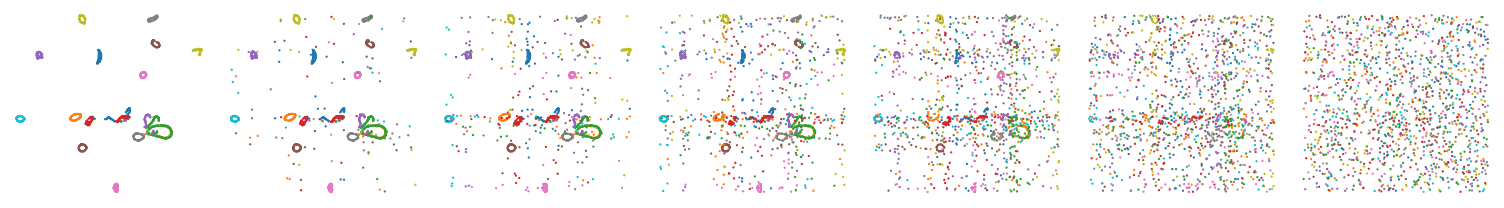

In [219]:
visualize_results(embs, labels, index=[0, 1, 3, 6, 11, 17, 24], s=1.5, path="./plot_embeddings/A")

In [220]:
results_list_dict = compute_metrics(raw, embs, labels, 25, "randomizing_emb")

100%|██████████| 25/25 [06:50<00:00, 16.40s/it]


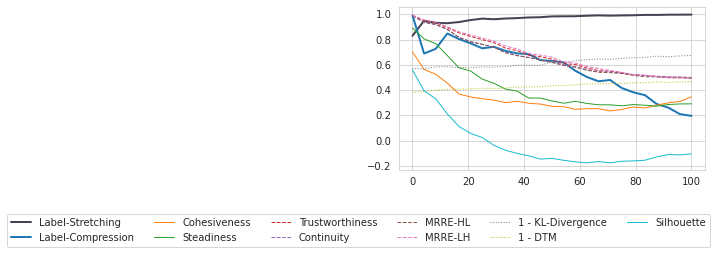

In [221]:
lineplot_results(results_list_dict, "randomizing_emb", x_list = np.linspace(0, 100, 25))

## Experiment B - about compression distortion

### Experiment B-1-1 (6 hyperspheres and overlapping classes)

In [222]:
raw, labels = np.load("./spheres_data/data/raw.npy"), np.load("./spheres_data/data/label.npy")
embs = []
for i in range(25):
	embs.append(np.load(f"./spheres_data/data/overlapping/circle_{i}.npy"))

In [223]:
results_list_dict = compute_metrics(raw, embs, labels, 25, "overlapping_circles")

100%|██████████| 25/25 [19:25<00:00, 46.63s/it]


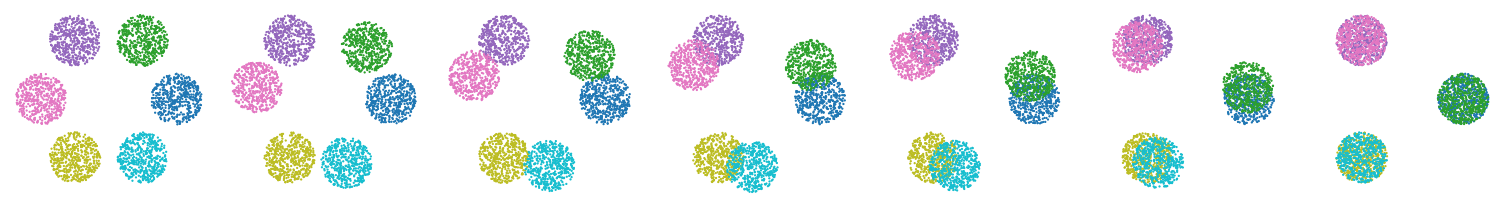

In [85]:
visualize_results(embs, labels, index=[0, 4, 8, 12, 16, 20, 24], s=1.5, path="./plot_embeddings/B-1-1")

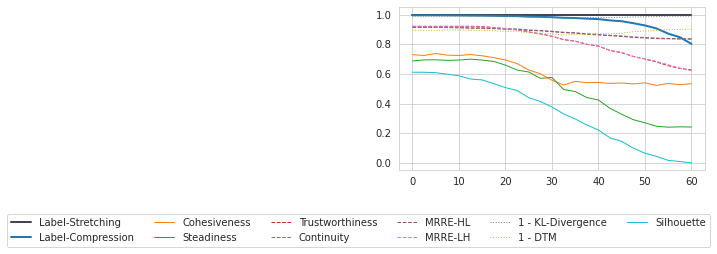

In [224]:
results_list_dict = read_results("overlapping_circles")
lineplot_results(results_list_dict, "overlapping_circles", x_list = np.linspace(0, 60, 25))

### Experiment B-1-2 (6 hyperspheres and overlapping classes - round2)

In [18]:
raw, labels = np.load("./spheres_data/data/raw.npy"), np.load("./spheres_data/data/label.npy")
embs = []
for i in range(25):
	embs.append(np.load(f"./spheres_data/data/overlapping_more/circle_{i}.npy"))

In [20]:
results_list_dict = compute_metrics(raw, embs, labels, 25, "overlapping_circles_more")

100%|██████████| 25/25 [11:20<00:00, 27.22s/it]


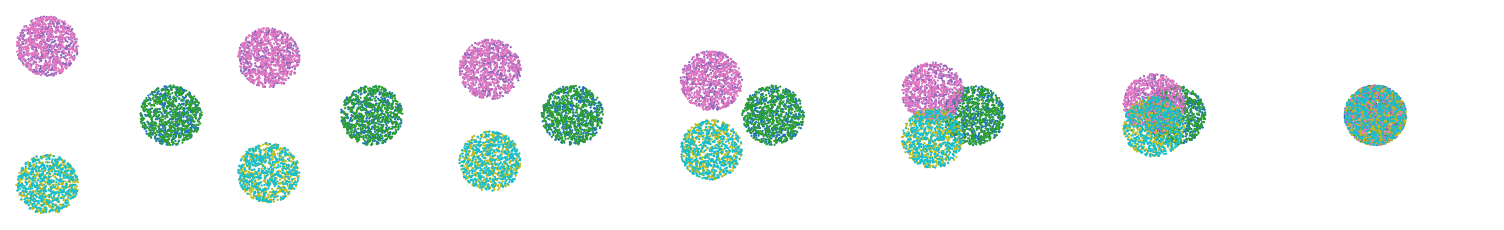

In [ ]:
visualize_results(embs, labels, index=[0, 4, 8, 12, 16, 20, 24], s=1.5, path="./plot_embeddings/B-1-2", ylen=3.3)

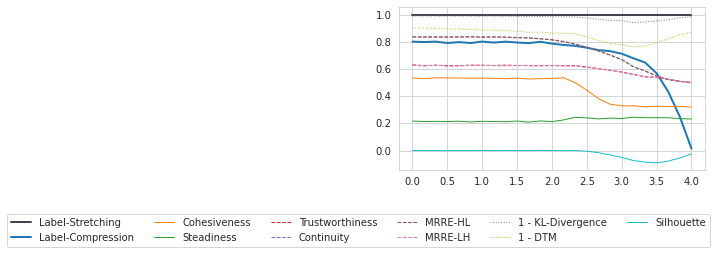

In [21]:
results_list_dict = read_results("overlapping_circles_more")
lineplot_results(results_list_dict, "overlapping_circles_more", x_list = np.linspace(0, 4, 25))

### Experiment B-2 (PCA Expansion test)

#### Currently with fashion-mnist dataset

In [25]:
## Dataset Generation
raw, labels = np.load("./labeled-datasets/npy/fashion_mnist/data.npy"), np.load("./labeled-datasets/npy/fashion_mnist/label.npy")
range_limit = 10
emb_pca = PCA(n_components=range_limit + 5).fit_transform(raw)

embs = []
for i in range(range_limit):
	embs.append(emb_pca[:, :i + 1])

In [26]:
## Compute metrics
results_list_dict = compute_metrics(raw, embs, labels, range_limit, "pca_expansion_digits")


100%|██████████| 10/10 [08:43<00:00, 52.39s/it]


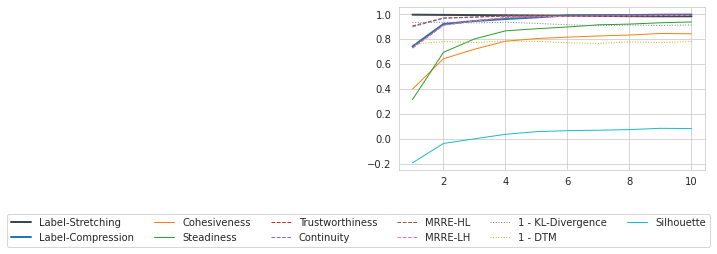

In [27]:
results_list_dict = read_results("pca_expansion_digits")
lineplot_results(results_list_dict, "pca_expansion_digits")

### Experiment C-1 (6 hyperspheres and overlapping hd spheres)

In [22]:
emb, labels = np.load("./spheres_data/data/overlapping_raw/emb.npy"), np.load("./spheres_data/data/overlapping_raw/label.npy")
raws = []
for i in range(25):
	raws.append(np.load(f"./spheres_data/data/overlapping_raw/raw_{i}.npy"))

In [23]:
results_list_dict = compute_metrics(raws, emb, labels, 25, "overlapping_raw")

100%|██████████| 25/25 [28:35<00:00, 68.61s/it]


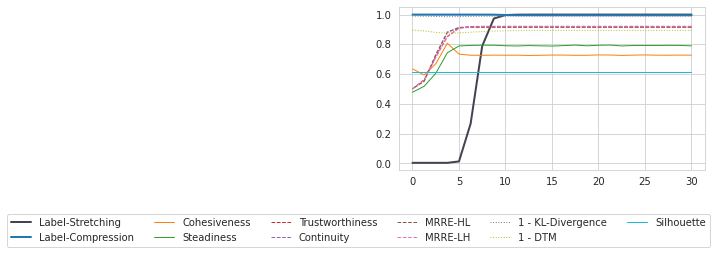

In [24]:
results_list_dict = read_results("overlapping_raw")
lineplot_results(results_list_dict, "overlapping_raw", x_list = np.linspace(30, 0, 25))

### Experiment C-2 (2D UMAP and high dimensional as PCA projections with decreasing number of PC

#### Currently With fashion mnist dataset

In [28]:
## Dataset Generation (with digits data)
raw_orig, labels = np.load("./labeled-datasets/npy/fashion_mnist/data.npy"), np.load("./labeled-datasets/npy/fashion_mnist/label.npy")
emb = np.load("./labeled-datasets_embedding/fashion_mnist/umap.npy")

component_interval = 10
raws = []
raw_pca = PCA(n_components=300).fit_transform(raw_orig)
for i in range(10):
	raw = raw_pca[:, i: i + component_interval]
	raws.append(raw)


In [29]:
## compute the metrics of the original data and save
results_list_dict = compute_metrics(raws, emb, labels, 10, "pca_decreasing_digits")

100%|██████████| 10/10 [04:16<00:00, 25.70s/it]


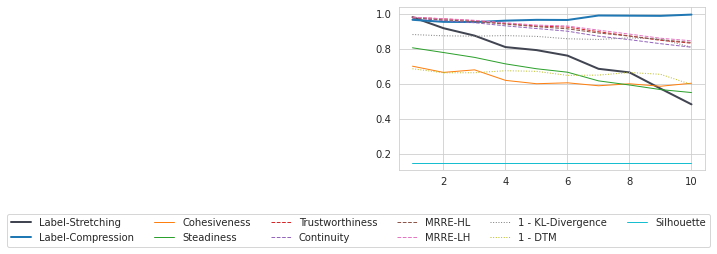

In [30]:
results_list_dict = read_results("pca_decreasing_digits")
lineplot_results(results_list_dict, "pca_decreasing")

### Visualizing Results

In [31]:
## read
tests = ["randomizing_emb", "overlapping_circles", "overlapping_circles_more", "pca_expansion_digits", "overlapping_raw", "pca_decreasing_digits"]
x_lists = [np.linspace(0, 100, 25), np.linspace(60, 0, 25), np.linspace(4, 0, 25), None, np.linspace(4, 0, 25), None, ]
y_labels = ["score", None, None, None, None, None]
x_labels = ["Randomization rate","angle btw two circles", "dist from a center", "rank of PC", "var btw hyperspheres", "rank of PC", ]
inverts = [False, True, True, False, True, False,]


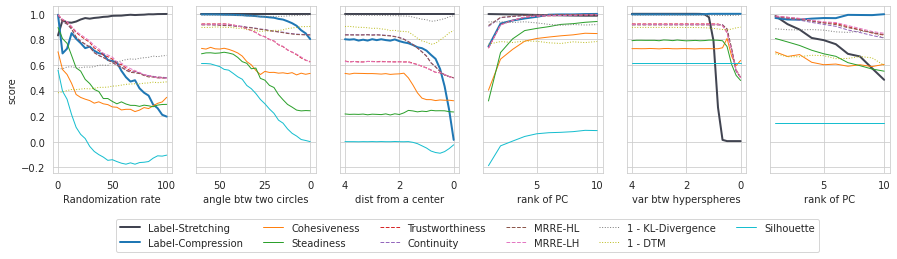

In [32]:
## plot for plots in the single figure

fig, axs = plt.subplots(1, 6, figsize=(15, 4), sharey=True)



for i, test in enumerate(tests):
	results_list_dict = read_results(test)
	lineplot_results(results_list_dict, test, x_list = x_lists[i], invert_x_axis=inverts[i], ax = axs[i], add_legend=True if i == 3 else False, y_label=y_labels[i], x_label=x_labels[i])

## add legend

plt.subplots_adjust(bottom=0.3)
plt.savefig(f"./plot/summarize.png", dpi=300)
plt.savefig(f"./plot/summarize.pdf", dpi=300)

### For appendix: reproduction test for B-2

In [45]:
datasets = [
	"weather", "optical_recognition_of_handwritten_digits", 
	"mnist64", "har", "coil20",
	"olivetti_faces", "cnae9", 
	"student_grade", 
]
dataset_name = [
	"Weather", "Optical Recognition", "Mnist 64", "HAR", "Coil-20",
	"Olivetti Faces", "CNAE-9",
	"Student Grade", 
]

In [41]:
for dataset in datasets:
	raw, labels = np.load(f"./labeled-datasets/npy/{dataset}/data.npy"), np.load(f"./labeled-datasets/npy/{dataset}/label.npy")
	range_limit = 10
	emb_pca = PCA(n_components=range_limit + 5).fit_transform(raw)
	embs = []
	for i in range(range_limit):
		embs.append(emb_pca[:, :i+1]) 
	

	results_list_dict = compute_metrics(raw, embs, labels, range_limit, f"pca_expansion_{dataset}")


100%|██████████| 10/10 [02:36<00:00, 15.69s/it]


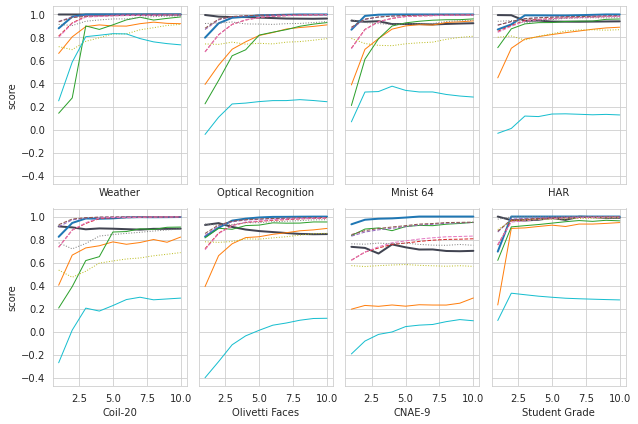

In [46]:
fig, axs = plt.subplots(2, 4, figsize=(9, 6), sharey=True, sharex=True)

for i, dataset in enumerate(datasets):
	results = read_results(f"pca_expansion_{dataset}")
	lineplot_results(
		results, dataset, 
		x_list = None, invert_x_axis=False,
		ax = axs[i // 4, i % 4],
		add_legend = False,
		y_label = "score" if i % 4 == 0 else None,
		x_label = dataset_name[i]
	)


plt.tight_layout()
plt.savefig("./plot/b2_reproduce.png", dpi=300)
plt.savefig("./plot/b2_reproduce.pdf", dpi=300)

### For appendix: reproduction test for C-2

In [43]:
### For appendix: reproduction test for B-2
for dataset in datasets:
	raw_orig, labels = np.load(f"./labeled-datasets/npy/{dataset}/data.npy"), np.load(f"./labeled-datasets/npy/{dataset}/label.npy")
	emb = np.load(f"./labeled-datasets_embedding/{dataset}/umap.npy")
	component_interval = 10
	range_limit = 10
	raws = []
	raw_pca = PCA(n_components=22).fit_transform(raw_orig)
	for i in range(range_limit):
		raws.append(raw_pca[:, i: i + component_interval])
	

	results_list_dict = compute_metrics(raws, emb, labels, range_limit, f"pca_decreasing_{dataset}")




100%|██████████| 10/10 [01:39<00:00,  9.95s/it]


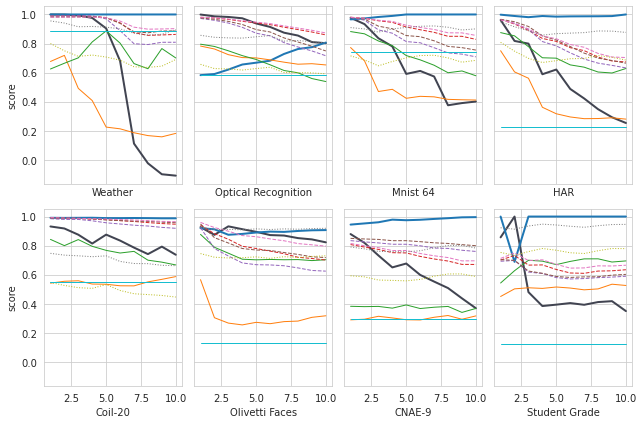

In [47]:
fig, axs = plt.subplots(2, 4, figsize=(9, 6), sharey=True, sharex=True)

for i, dataset in enumerate(datasets):
	results = read_results(f"pca_decreasing_{dataset}")
	lineplot_results(
		results, dataset, 
		x_list = None, invert_x_axis=False,
		ax = axs[i // 4, i % 4],
		add_legend = False,
		y_label = "score" if i % 4 == 0 else None,
		x_label = dataset_name[i]
	)


plt.tight_layout()
plt.savefig("./plot/c2_reproduce.png", dpi=300)
plt.savefig("./plot/c2_reproduce.pdf", dpi=300)